In [12]:
%tensorflow_version 1.x

In [13]:
%pylab inline

import os
import sys
import time
import h5py


import random
import tensorflow as tf
import logging
from tqdm import tqdm

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import UpSampling2D, Cropping2D

from decimal import Decimal

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
SEED = 123

random.seed(SEED)
np.random.seed(SEED)
# tf.random.set_seed(SEED)
tf.set_random_seed(SEED)

In [16]:
# input settings
DATA_DIR = '/content/drive/MyDrive/ML4Cyber/data'
DATA_FILE = 'clean_test_data.h5'
MODEL_DIR = '/content/drive/MyDrive/ML4Cyber/model'
# MODEL_FILE = 'sunglasses_bd_net.h5'
MODEL_FILE = 'anonymous_bd_net.h5'


In [17]:
def load_dataset(data_file, datatype='youtubeface', batchsize=64):
    print('loading data file:{}'.format(DATA_FILE))
    if datatype == 'im':
        dataset = {}
        keys=['X_test', 'Y_test']
        with h5py.File(data_file, 'r') as hf:
            for name in keys:
                dataset[name] = np.array(hf.get(name))
        x_data = np.array(dataset['X_test'], dtype='float32')
        y_data = np.array(dataset['Y_test'], dtype='float32')
        
    elif datatype == 'youtubeface':
        data = h5py.File(data_file, 'r')
        x_data = np.array(data['data'])
        y_data = np.array(data['label'])
        x_data = x_data.transpose((0,2,3,1))

    print('X_test shape %s' % str(x_data.shape))
    print('Y_test shape %s' % str(y_data.shape))
    # print('loading into dataloader')
    # datagen = ImageDataGenerator()
    # dataloader = datagen.flow(x_data, y_data, batch_size=batchsize)
    # sample_num = x_data.shape[0]
    # datashape = x_data.shape[1:]


    return x_data, y_data

In [18]:
x_data, y_data = load_dataset(os.path.join(DATA_DIR, DATA_FILE))
model = load_model(os.path.join(MODEL_DIR, MODEL_FILE))
print('loading model file: ', MODEL_FILE)

loading data file:clean_test_data.h5
X_test shape (12830, 55, 47, 3)
Y_test shape (12830,)
loading model file:  anonymous_bd_net.h5


In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 55, 47, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

In [26]:
logger = logging.getLogger(__name__)

class NeuralCleanse:

    def __init__(
        self,
        model,
        use_logits: bool = False,
        channels_first: bool = False,
        # clip_values: Optional["CLIP_VALUES_TYPE"] = None,
        # preprocessing_defences: Union["Preprocessor", List["Preprocessor"], None] = None,
        # postprocessing_defences: Union["Postprocessor", List["Postprocessor"], None] = None,
        # preprocessing: "PREPROCESSING_TYPE" = (0, 1),
        input_shape = [55, 47, 3],
        input_layer: int = 0,
        output_layer: int = 0,
        steps: int = 150,
        init_cost: float = 1e-3,
        norm = 1,
        learning_rate: float = 0.1,
        attack_success_threshold: float = 0.98,
        patience: int = 5,
        early_stop: bool = True,
        early_stop_threshold: float = 0.98,
        early_stop_patience: int = 10,
        cost_multiplier: float = 1.5,
        batch_size: int = 64,
        num_classes = 1283,
    ):

        self.model = model
        self.steps = steps
        self.init_cost = init_cost
        self.norm = norm
        self.learning_rate = learning_rate
        self.attack_success_threshold = attack_success_threshold
        self.patience = patience
        self.early_stop = early_stop
        self.early_stop_threshold = early_stop_threshold
        self.early_stop_patience = early_stop_patience
        self.cost_multiplier_up = cost_multiplier
        self.cost_multiplier_down = cost_multiplier ** 1.5
        self.batch_size = batch_size
        self.top_indices = []
        self.activation_threshold = 0
        self.num_classes = num_classes

        mask = np.random.uniform(size=input_shape)
        pattern = np.random.uniform(size=input_shape)
        self.epsilon = K.epsilon()

        # Normalize mask between [0, 1]
        self.mask_tensor_raw = K.variable(mask)
        # self.mask_tensor = K.expand_dims(K.tanh(self.mask_tensor_raw) / (2 - self.epsilon) + 0.5, axis=0)
        self.mask_tensor = K.tanh(self.mask_tensor_raw) / (2 - self.epsilon) + 0.5

        # Normalize pattern between [0, 1]
        self.pattern_tensor_raw = K.variable(pattern)
        self.pattern_tensor = K.expand_dims(K.tanh(self.pattern_tensor_raw) / (2 - self.epsilon) + 0.5, axis=0)

        reverse_mask_tensor = K.ones_like(self.mask_tensor) - self.mask_tensor
        input_tensor = K.placeholder(model.input_shape)
        x_adv_tensor = reverse_mask_tensor * input_tensor + self.mask_tensor * self.pattern_tensor

        output_tensor = self.model(x_adv_tensor)
        y_true_tensor = K.placeholder(model.outputs[0].shape.as_list())

        self.loss_acc = categorical_accuracy(output_tensor, y_true_tensor)
        self.loss_ce = categorical_crossentropy(output_tensor, y_true_tensor)

        if self.norm == 1:
            # TODO: change 3 to dynamically set img_color
            self.loss_reg = K.sum(K.abs(self.mask_tensor)) / 3
        elif self.norm == 2:
            self.loss_reg = K.sqrt(K.sum(K.square(self.mask_tensor)) / 3)



        self.cost = self.init_cost
        self.cost_tensor = K.variable(self.cost)
        self.loss_combined = self.loss_ce + self.loss_reg * self.cost_tensor
        self.opt = Adam(lr=self.learning_rate, beta_1=0.5, beta_2=0.9)
        # self.opt = optimizer

        self.updates = self.opt.get_updates(
            params=[self.pattern_tensor_raw, self.mask_tensor_raw], loss=self.loss_combined
        )
        self.train = K.function(
            [input_tensor, y_true_tensor],
            [self.loss_ce, self.loss_reg, self.loss_combined, self.loss_acc],
            updates=self.updates,
        )


    def reset(self):
        """
        Reset the state of the defense
        :return:
        """

        self.cost = self.init_cost
        K.set_value(self.cost_tensor, self.init_cost)
        K.set_value(self.opt.iterations, 0)
        for weight in self.opt.weights:
            K.set_value(weight, np.zeros(K.int_shape(weight)))

    def generate_backdoor(
        self, x_val: np.ndarray, y_val: np.ndarray, y_target: np.ndarray
    ):
        """
        Generates a possible backdoor for the model. Returns the pattern and the mask
        :return: A tuple of the pattern and mask for the model.
        """
        import keras.backend as K
        from keras_preprocessing.image import ImageDataGenerator

        self.reset()
        datagen = ImageDataGenerator()
        gen = datagen.flow(x_val, y_val, batch_size=self.batch_size)
        mask_best = None
        pattern_best = None
        reg_best = float("inf")
        cost_set_counter = 0
        cost_up_counter = 0
        cost_down_counter = 0
        cost_up_flag = False
        cost_down_flag = False
        early_stop_counter = 0
        early_stop_reg_best = reg_best
        mini_batch_size = len(x_val) // self.batch_size
        for _ in tqdm(range(self.steps), desc="Generating backdoor for class {}".format(np.argmax(y_target))):
            loss_reg_list = []
            loss_acc_list = []

            for _ in range(mini_batch_size):
                x_batch, _ = gen.next()
                y_batch = to_categorical([y_target] * x_batch.shape[0], self.num_classes) 
                batch_loss_ce, batch_loss_reg, batch_loss, batch_loss_acc = self.train([x_batch, y_batch])

                loss_reg_list.extend(list(batch_loss_reg.flatten()))
                loss_acc_list.extend(list(batch_loss_acc.flatten()))

            avg_loss_reg = np.mean(loss_reg_list)
            avg_loss_acc = np.mean(loss_acc_list)

            # save best mask/pattern so far
            if avg_loss_acc >= self.attack_success_threshold and avg_loss_reg < reg_best:
                mask_best = K.eval(self.mask_tensor)
                pattern_best = K.eval(self.pattern_tensor)
                reg_best = avg_loss_reg

            # check early stop
            if self.early_stop:
                if reg_best < float("inf"):
                    if reg_best >= self.early_stop_threshold * early_stop_reg_best:
                        early_stop_counter += 1
                    else:
                        early_stop_counter = 0
                early_stop_reg_best = min(reg_best, early_stop_reg_best)

                if cost_down_flag and cost_up_flag and early_stop_counter >= self.early_stop_patience:
                    logger.info("Early stop")
                    break

            # cost modification
            if avg_loss_acc >= self.attack_success_threshold:
                cost_set_counter += 1
                if cost_set_counter >= self.patience:
                    self.cost = self.init_cost
                    K.set_value(self.cost_tensor, self.cost)
                    cost_up_counter = 0
                    cost_down_counter = 0
                    cost_up_flag = False
                    cost_down_flag = False
            else:
                cost_set_counter = 0

            if avg_loss_acc >= self.attack_success_threshold:
                cost_up_counter += 1
                cost_down_counter = 0
            else:
                cost_up_counter = 0
                cost_down_counter += 1

            if cost_up_counter >= self.patience:
                cost_up_counter = 0
                self.cost *= self.cost_multiplier_up
                K.set_value(self.cost_tensor, self.cost)
                cost_up_flag = True
            elif cost_down_counter >= self.patience:
                cost_down_counter = 0
                self.cost /= self.cost_multiplier_down
                K.set_value(self.cost_tensor, self.cost)
                cost_down_flag = True

        if mask_best is None:
            mask_best = K.eval(self.mask_tensor)
            pattern_best = K.eval(self.pattern_tensor)
        print("attact success:{}, loss:{}, cost:{}".format(avg_loss_acc, avg_loss_reg, self.cost))
        return mask_best, pattern_best



In [27]:
h = NeuralCleanse(model)

In [ ]:
mask, pattern = h.generate_backdoor(x_data, y_data,y_target=0)

Generating backdoor for class 0:   7%|▋         | 10/150 [04:32<1:03:45, 27.33s/it]

In [23]:
def image_process(array):
    if len(array.shape) > 3:
        array = np.squeeze(array, axis=0)
    clip_array = np.clip(array, 0., 255.)
    return clip_array

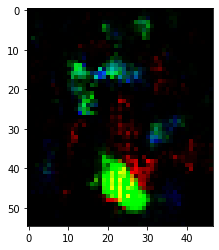

In [24]:
new_mask = image_process(mask)
plt.imshow(new_mask)

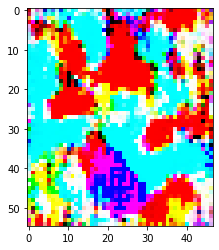

In [25]:
new_pattern = image_process(pattern)
plt.imshow(new_pattern)


Generating backdoor for class 0: 100%|██████████| 100/100 [42:42<00:00, 25.63s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:37<00:00, 26.18s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:27<00:00, 26.07s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:38<00:00, 26.19s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:14<00:00, 25.95s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:48<00:00, 26.28s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:30<00:00, 26.11s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:54<00:00, 26.35s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [44:23<00:00, 26.64s/it]

Generating backdoor for class 0: 100%|██████████| 100/100 [43:48<00:00, 26.28s/it]


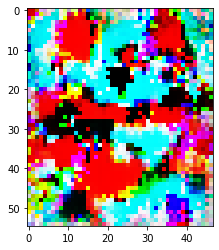

In [ ]:
mask_list = np.array([])
pattern_list = np.array([])
for i in range(10):
    mask, pattern = h.generate_backdoor(x_data, y_data,y_target=i)
    mask_list = np.append(mask_list, mask)
    pattern_list = np.append(pattern_list, pattern)
    # try:
    image_process(mask)
    image_process(pattern)
model_name, _ = MODEL_FILE.split('.')
np.save('mask_{}_1to10.npy'.format(model_name), mask_list)
np.save('pattern_{}_1to10.npy'.format(model_name), pattern_list)


In [ ]:
model_name, _ = MODEL_FILE.split('.')
np.save(os.path.join('/content/drive/MyDrive/ML4Cyber/data','mask_{}.npy'.format(model_name)), mask)
np.save('pattern_{}.npy'.format(model_name), pattern)

In [ ]:
a = np.array([])
b = np.array([2, 3])
a = np.append(a,b)

In [ ]:
a

array([2., 3.])